In [1]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(2048)
environ['n_epochs']= '1000'
environ['batch_norm']= 'True'
environ['loss_func']='MSE'
environ['layers'] = '500 300 120 80 30'
environ['dropouts'] = '0.2'+' 0.3'*4
environ['log'] = 'False'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:0'
environ['dataset'] = 'data/speedup_dataset3.pkl'

%run utils.ipynb

In [2]:
train_dl, val_dl, test_dl = train_dev_split(dataset, batch_size, num_workers, log=log)

db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

In [3]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)
    
if loss_func == 'MSE':
    criterion = nn.MSELoss()
else:
    criterion = mape_criterion

l = fai.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion],
               callback_fns=[partial(EarlyStoppingCallback, mode='min', 
                                        monitor='mape_criterion', min_delta=0.1, patience=500)])

if optimizer == 'SGD':
    l.opt_func = optim.SGD 
    

In [4]:
l = l.load(f"training_tuning_l2")

In [50]:
l.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


IndexError: list index out of range

In [ ]:
l.recorder.plot()

In [8]:
losses = []

for lr in [0.1, 0.01, 0.001, 0.0001]:
    l.fit_one_cycle(150, lr)
    
    losses.append(l.recorder.losses)
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
    l = fai.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion],
               callback_fns=[partial(EarlyStoppingCallback, mode='min', 
                                        monitor='mape_criterion', min_delta=0.1, patience=500)])
    

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,74.129715,71.761269,71.761269,0.825816
2,68.933952,66.092979,66.092979,0.657644
3,67.739174,65.797287,65.797287,0.597088
4,66.937553,65.451782,65.451782,0.670642
5,66.673203,64.836830,64.836830,0.680429
6,66.160767,63.825073,63.825073,0.706331
7,66.129143,64.092758,64.092758,0.628661
8,66.332947,65.573387,65.573387,0.707224
9,66.217003,64.257729,64.257729,0.699780
10,66.006088,69.592033,69.592033,0.634401


epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,78.732628,74.668945,74.668945,0.785543
2,73.747482,68.938980,68.938980,0.721840
3,71.185043,68.270363,68.270363,0.703981
4,69.435204,65.281067,65.281067,0.608692
5,68.609169,65.847290,65.847290,0.646976
6,67.569168,65.308105,65.308105,0.612554
7,66.567024,63.464306,63.464306,0.650067
8,65.510147,62.813137,62.813137,0.661986
9,64.402550,62.850044,62.850044,0.629169
10,63.164013,60.025162,60.025162,0.655814


epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,85.475044,78.203087,78.203087,0.859930
2,81.747810,77.755051,77.755051,0.858159
3,78.602066,75.115341,75.115341,0.829927
4,76.386917,72.833954,72.833954,0.759531
5,74.345993,71.072212,71.072212,0.714779
6,72.541962,69.128082,69.128082,0.704221
7,71.019814,67.677841,67.677841,0.626232
8,69.782219,67.188934,67.188934,0.633810
9,68.920784,66.456329,66.456329,0.655580
10,68.174614,65.793755,65.793755,0.617052


epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,104.514160,77.406235,77.406235,0.669803
2,98.514900,77.565689,77.565689,0.644120
3,95.915794,77.693497,77.693497,0.704989
4,92.156853,77.824066,77.824066,0.770047
5,88.956642,78.246147,78.246147,0.930589
6,85.917107,78.377357,78.377357,1.010906
7,84.112511,78.934227,78.934227,1.095024
8,82.054459,78.700066,78.700066,0.993953
9,81.039833,78.687019,78.687019,1.029927
10,80.045441,78.408630,78.408630,0.921155


In [9]:
len(losses[3])

37200

In [11]:
for i in range(4):
    losses[i] = [sum(losses[i][j:j+120])/120 for j in range(0, len(losses[i]), 120)]

In [36]:
len(losses[0])

100

In [14]:
plt.rcParams['figure.figsize'] = [40, 30]

/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Second argument '0.1' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  if sys.path[0] == '':
/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Second argument '0.01' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  del sys.path[0]
/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Second argument '0.001' is ambiguous: could be a color spec but is in data; using as data.  Either rename the entry in data or use three arguments to plot.
  
/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Second argument '0.0001' is ambiguous: could be a colo

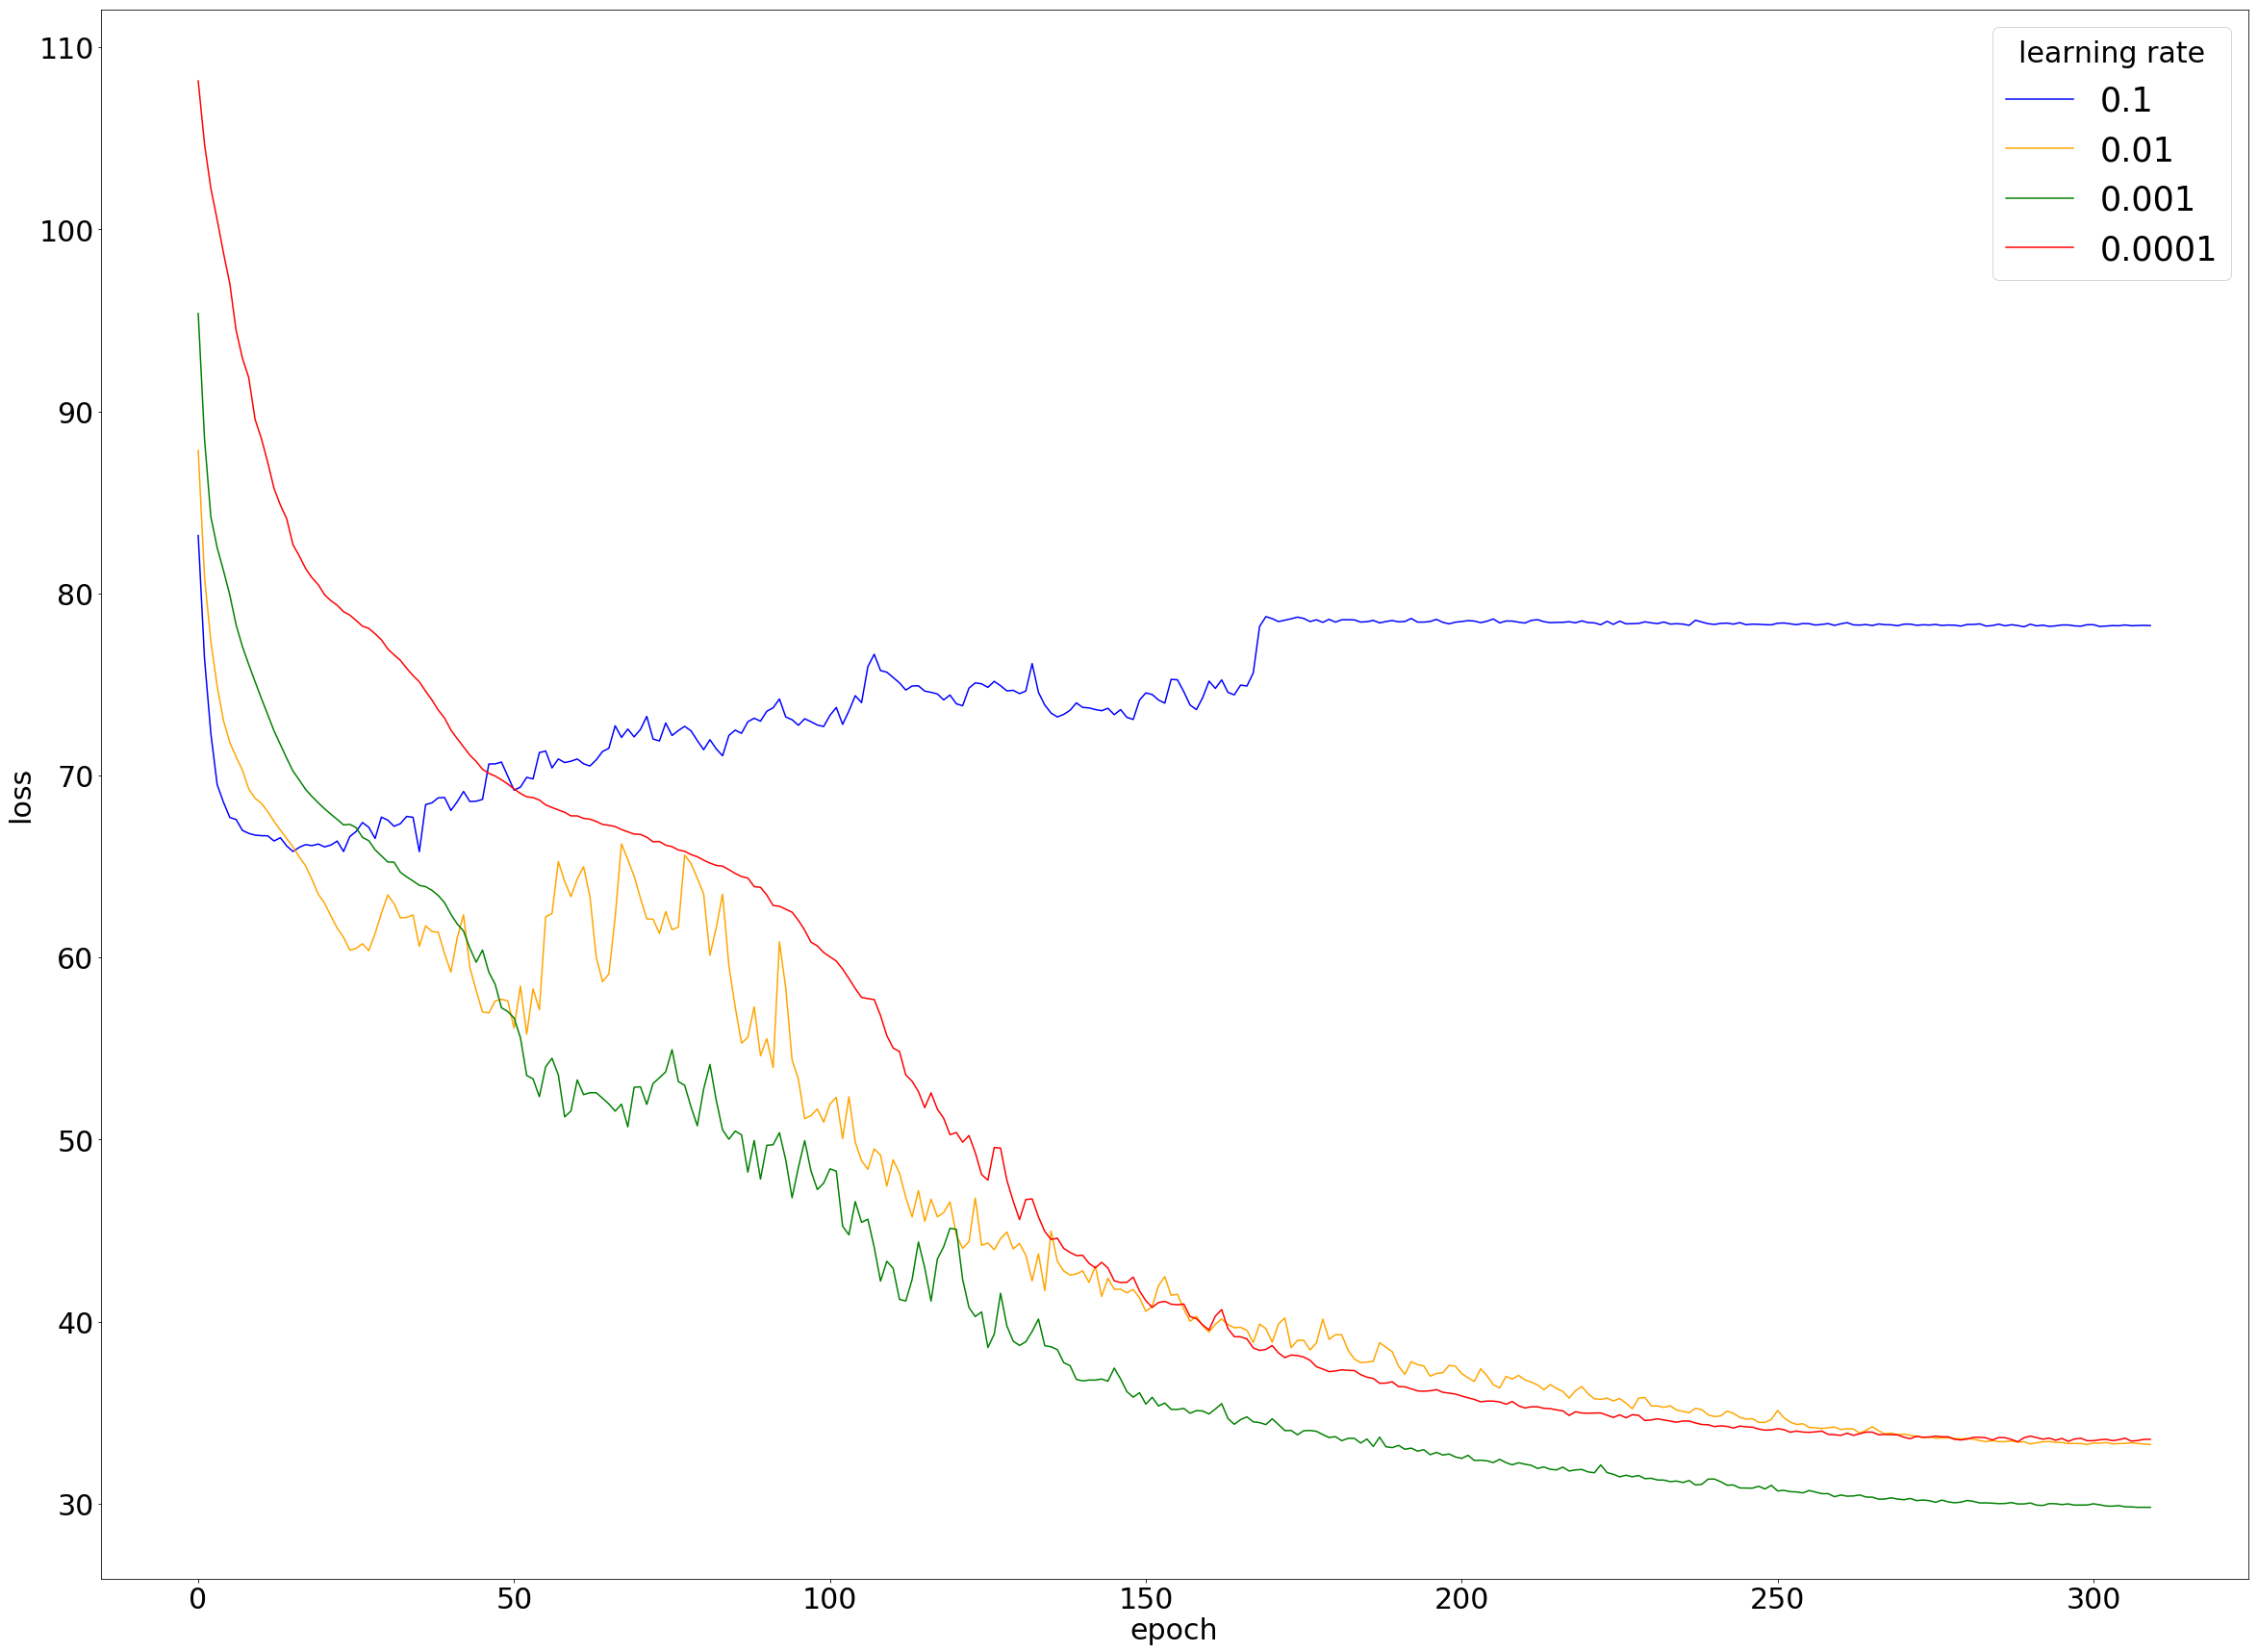

In [30]:
df = pd.DataFrame()

df['0.1'] = losses[0]
df['0.01'] = losses[1]
df['0.001'] = losses[2]
df['0.0001'] = losses[3]

df['x'] = df.index

df1 = df

plt.plot('x', '0.1', data=df1, color='blue')
plt.plot('x', '0.01', data=df1, color='orange')
plt.plot('x', '0.001', data=df1, color='green')
plt.plot('x', '0.0001', data=df1, color='red')
plt.ylabel('loss', fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('epoch', fontsize=30)
plt.xticks(fontsize=30)
plt.legend(prop={"size": 35}, title="learning rate", title_fontsize=30)


In [34]:
lr = 1e-03

In [ ]:
l.fit_one_cycle(500, lr)

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,0.475406,0.420576,81.282562,0.647358
2,0.405994,0.366841,96.016930,0.604133
3,0.344525,0.339823,118.622673,0.581630
4,0.301959,0.294398,151.522369,0.541339
5,0.279079,0.265475,176.185654,0.513714
6,0.257754,0.260151,201.353348,0.509145
7,0.244165,0.243444,218.734299,0.492636
8,0.240072,0.242082,223.577301,0.490018
9,0.227321,0.218746,227.491348,0.466438
10,0.223451,0.224616,227.358154,0.473307


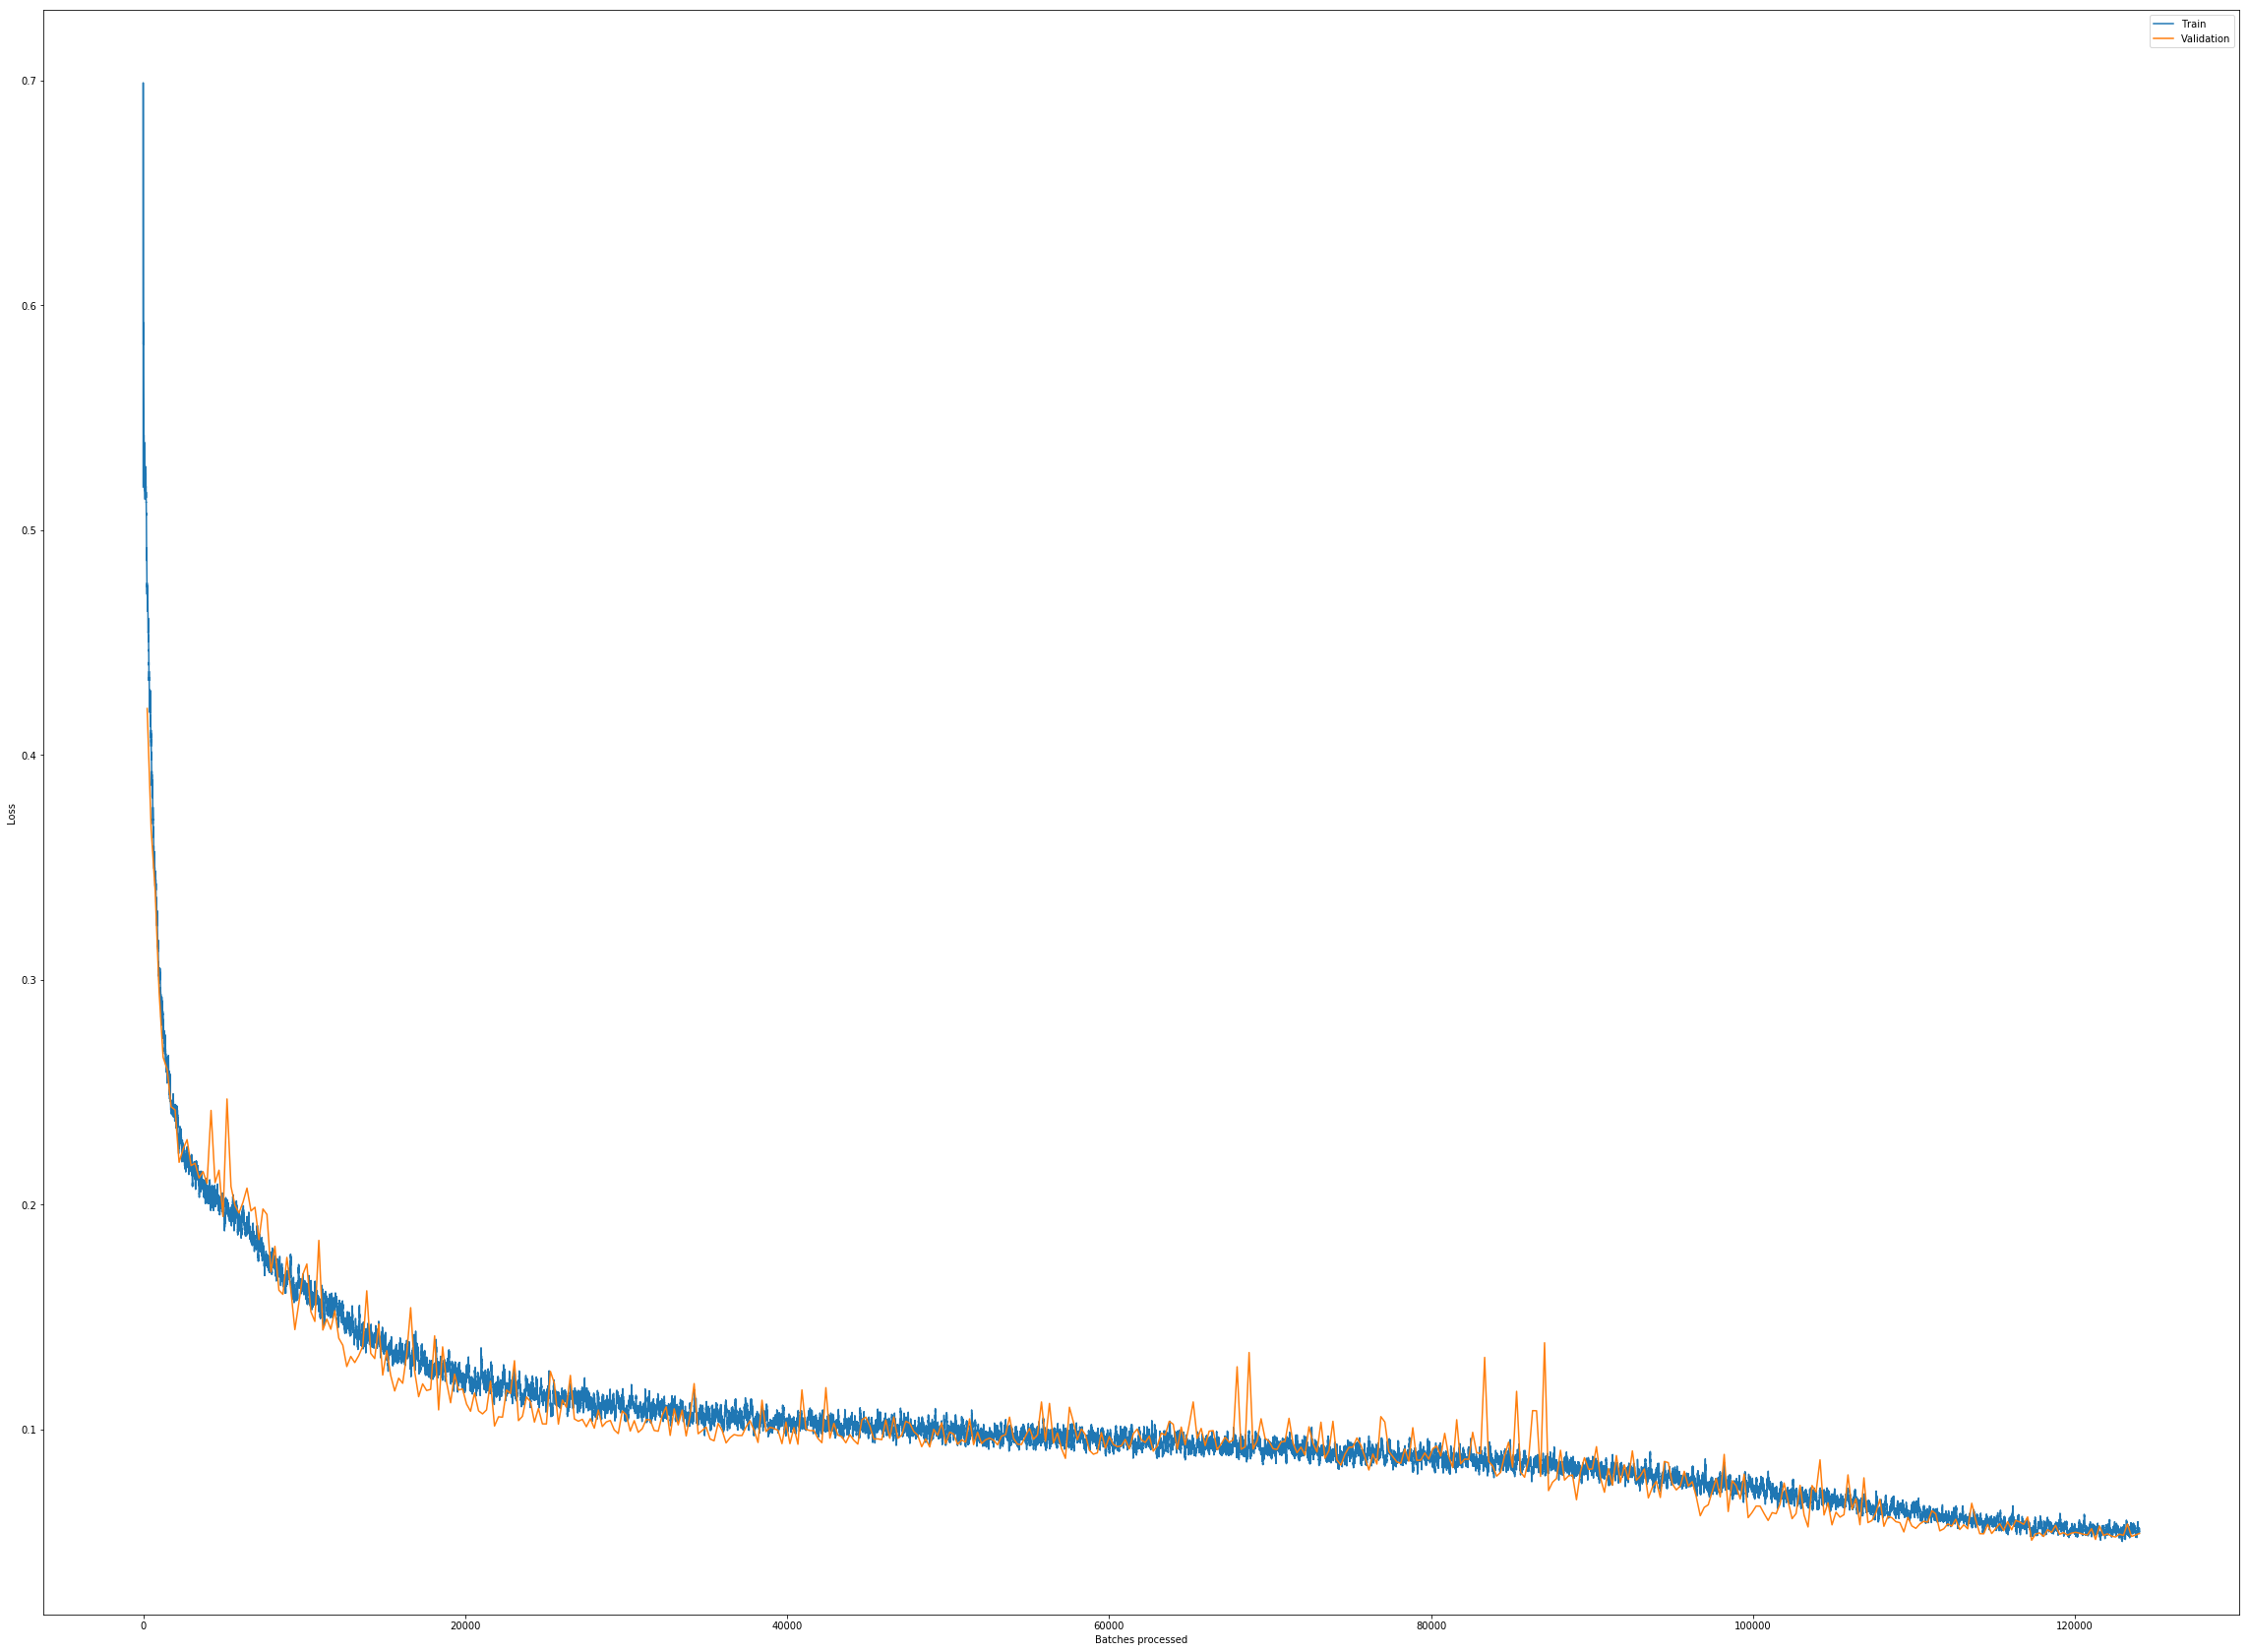

In [38]:
l.recorder.plot_losses()

In [39]:
l.save(f"training_tuning_l2")

In [5]:
val_df = get_results_df(val_dl, l.model)
train_df = get_results_df(train_dl, l.model)
test_df = get_results_df(test_dl, l.model)

In [49]:
df = val_df

In [51]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.482927,0.469633,0.111734,45.108513
std,0.679316,0.748854,0.203059,59.437885
min,0.000000,0.011766,0.000004,0.000876
25%,0.160788,0.119905,0.030099,10.576813
50%,0.342015,0.299996,0.059738,24.266205
75%,0.629870,0.609846,0.122063,59.659491
max,8.527840,11.273418,3.859247,831.365295


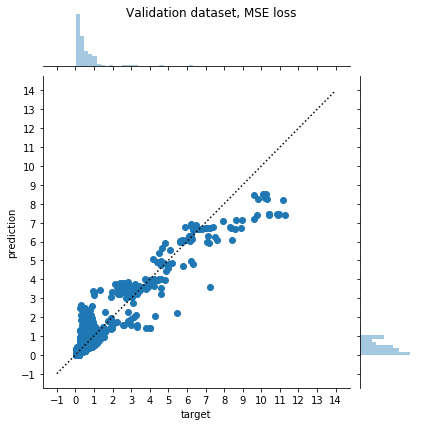

In [52]:
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")

In [14]:
df_ = df.sort_values(by=["APE"])

df_['x'] = range(len(df_))

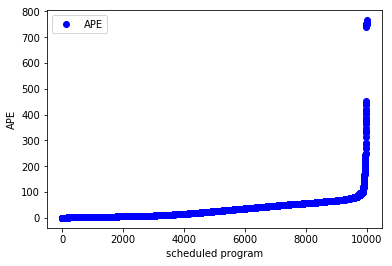

In [15]:
plt.plot('x', 'APE', 'bo', data=df_)


plt.xlabel('scheduled program')
plt.ylabel('APE')
plt.legend()

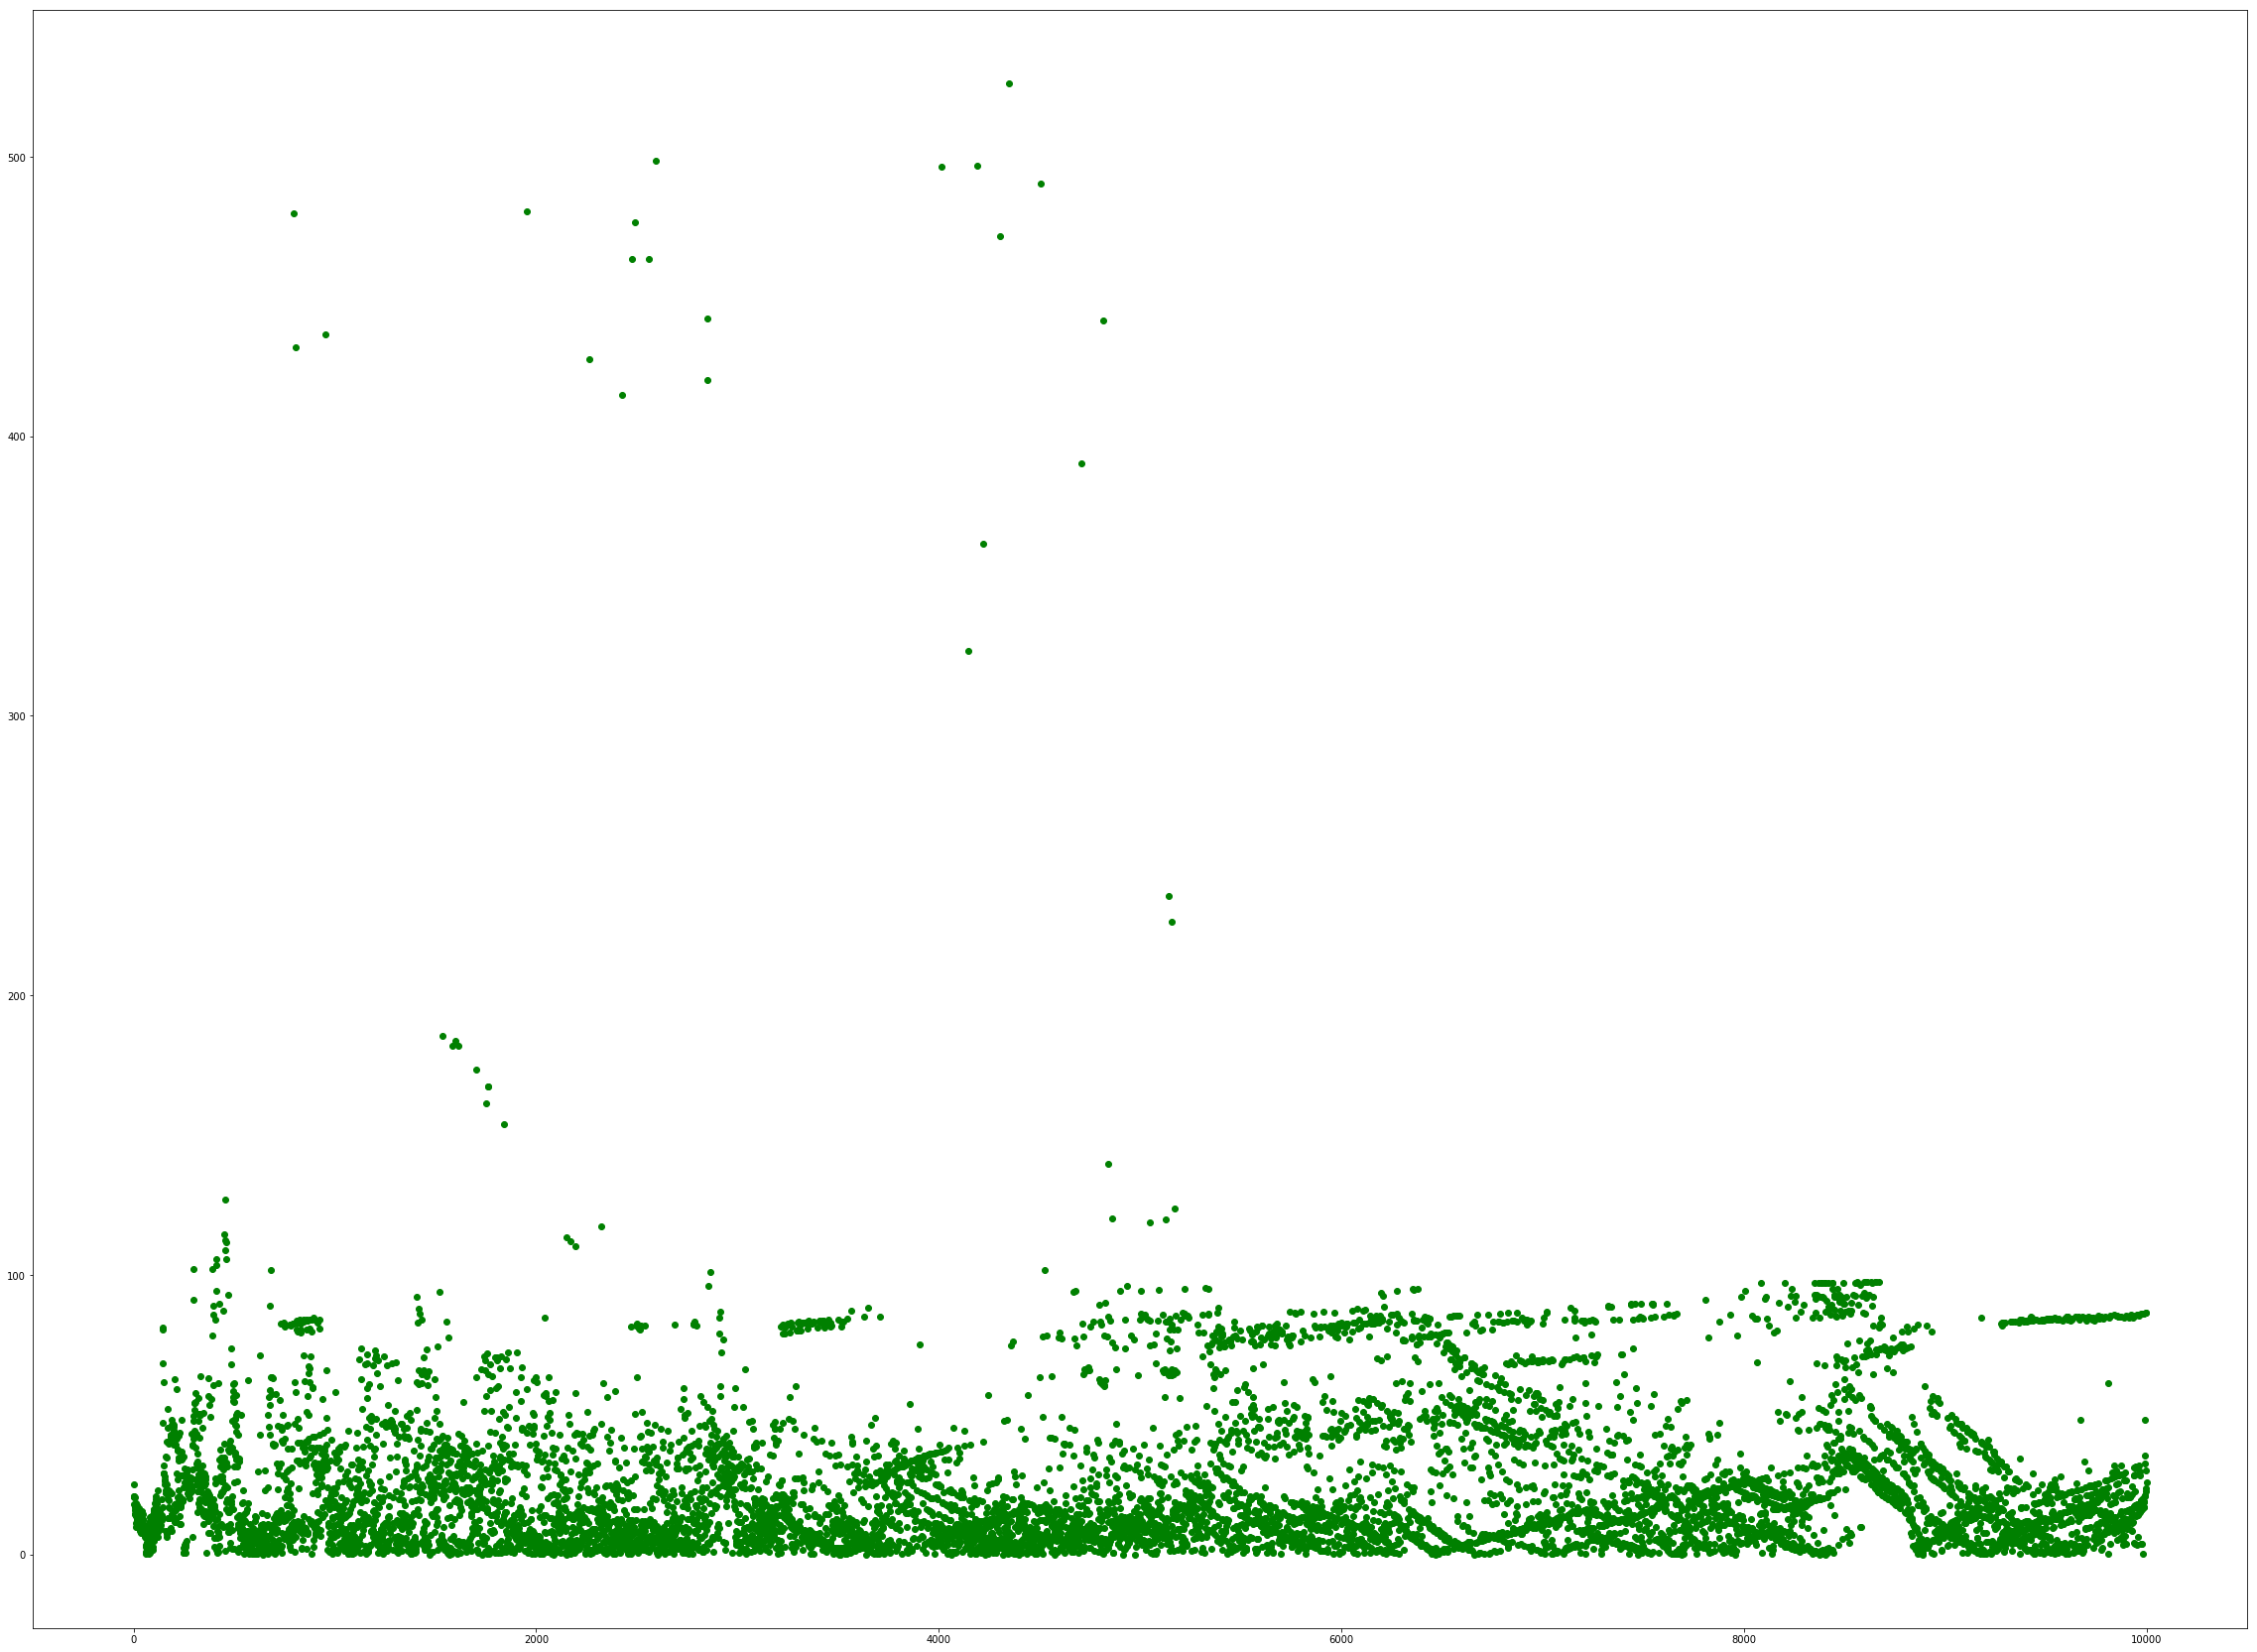

In [134]:
plt.plot('x', 'APE', 'go', data=df_)

In [6]:
df = pd.concat([val_df, test_df])

In [7]:
df1 = df[:][['prediction','target', 'name']]

In [8]:
def evaluation_df(df1, n=1):
    eval_df = pd.DataFrame(columns=['performance', 'achieved_speedup', 'max_speedup', 'schedules_count'])

    for prog in set(df1.name):
        tmp_df = df1[df1.name == prog].sort_values(by=["prediction"], ascending=False)
        
        speedup = tmp_df.iloc[list(range(n))].target.max()

        perf = speedup / tmp_df.target.max()
        abs_diff =  tmp_df.target.max() - speedup


        new = pd.DataFrame()
        new['achieved_speedup'] = [speedup]
        new['performance'] = [perf]
        new['max_speedup'] = [tmp_df.target.max()]
        new['schedules_count'] = [len(tmp_df.target)]
 
        eval_df = pd.concat([eval_df, new],
                   ignore_index=True)         
    
    
   
    return eval_df



In [13]:
eval_df = evaluation_df(df1, n=5)

/data/scratch/henni-mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [14]:
eval_df.performance.describe()

count    29.000000
mean      0.893790
std       0.096194
min       0.553684
25%       0.835778
50%       0.907576
75%       0.962869
max       1.000000
Name: performance, dtype: float64